In [1]:
import numpy as np
import csv as csv
import json    
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Plotting functions
def plot_first_data(data, samples = 200, avgline = True):
    plt.plot(np.linspace(0, samples, samples),data[:samples])
    plt.xticks(rotation=45)
    if avgline:
        plt.hlines(np.mean(data[:samples]), 0,samples) 

def plot_last_data(data, samples = 200, avgline = True):
    plt.plot(np.linspace((len(data)-samples), len(data), samples),data[-samples:])
    plt.xticks(rotation=45)
    if avgline:
        plt.hlines(np.mean(data[-samples:]), (len(data)-samples),len(data))  
        
def plot_slice_data(data, sample_i = 0, sample_f = 200, avgline = True):
    samples = sample_f-sample_i
    plt.plot(np.linspace(sample_i, sample_f, sample_f-sample_i),data[sample_i:sample_f])
    plt.xticks(rotation=45)
    if avgline:
        plt.hlines(np.mean(data[sample_i:sample_f]), sample_i,sample_f)   

In [3]:
import biosppy.signals.resp as resp
# Returns
#    -------
#    ts : array
#        Signal time axis reference (seconds).
#    filtered : array
#        Filtered Respiration signal.
#    zeros : array
#        Indices of Respiration zero crossings.
#    resp_rate_ts : array
#        Respiration rate time axis reference (seconds).
#    resp_rate : array
#        Instantaneous respiration rate (Hz).

In [4]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [5]:
# Last points linreg
def lastpoint_linreg(data, samples = 100, sampling_rate = 200):
    """Calculates a linear regression a determines a hold flag based on slope
    Parameters
    ----------
    data : signal to be processed, ideally filtered
    
    samples : samples needed
    
    sampling_rate : acquisition sampling rate
    
    Returns
    ----------
    hold_flag: flag informing whther there is an inhale or exhale
    OR 
    regression coefficient and intercept: 

    
    """
    reg = LinearRegression().fit(np.linspace(0,1/sampling_rate*samples, samples).reshape(-1,1), data[-samples:].reshape(-1,1))
    return reg.coef_[0], reg.intercept_

In [6]:
# Area fraction
def area_fraction(data, bits = 12):
    """Calculates the area fraction covered by the data
    Parameters
    ----------
    data : input signal to be processed
        
    bits : number of resolution bits (digital) R-IoT=12, BITalino = 10, IMU/bsp = 16
    
    Returns
    ----------
    fraction of area covered by the signal

    
    """
    frac = np.mean(np.absolute(data))/(2**bits) 
    return frac

In [7]:
# Resp intervals
def calc_resp_intervals(data, last_breath = False):
    """Calculates respiration intervals and indicates inhale/exhale
    Parameters
    ----------
    data : breathing signal to be processed
    
    last_breath : flag that indicates whether single/mult breath analysis is requested
    
    Returns
    ----------
    interval_lengths: list of breathing interval lenghts
    
    interval_breathe_in: list of breathe in True/False flags
    """
    processed_data = resp.resp(signal=data, sampling_rate=200, show=False)
    filtered_signal = processed_data[1]
    inst_resp_rate = processed_data[4]
    
    signal_diff = np.diff(filtered_signal)
    signal_signum = signal_diff > 0
    
    resp_changes = np.append(np.where(signal_signum[:-1] != signal_signum[1:])[0], [len(signal_signum) - 1])
    
    if not last_breath:
        resp_intervals = np.append([0], resp_changes)
        interval_lengths = np.diff(resp_intervals)
        interval_breathe_in = [signal_signum[i] for i in resp_changes]
        return interval_lengths, interval_breathe_in
    
    else:
        if len(resp_changes) > 1:
            last_interval = resp_changes[-1] - resp_changes[-2]
        else:
            last_interval = resp_changes[-1] 
                   
        return last_interval, signal_signum[resp_changes[-1]]

In [8]:
# Amplitudes
def calc_amplitudes(data, last_breath = False):
    """Calculates respiration intervals and indicates inhale/exhale
    Parameters
    ----------
    data : breathing signal to be processed
    
    last_breath : flag that indicates whether single/mult breath analysis is requested
    
    Returns
    ----------
    interval_lengths: list of breathing interval lenghts
    
    amplitude: list of amplitude
    """
    processed_data = resp.resp(signal=data, sampling_rate=200, show=False)
    filtered_signal = processed_data[1]
    inst_resp_rate = processed_data[4]
    
    signal_diff = np.diff(filtered_signal)
    signal_signum = signal_diff > 0
    
    resp_changes = np.append(np.where(signal_signum[:-1] != signal_signum[1:])[0], [len(signal_signum) - 1])
    resp_amplitude = np.diff(np.append([0],data[resp_changes]))[1:-1]
    
    if not last_breath:
        resp_intervals = np.append([0], resp_changes)
        interval_lengths = np.diff(resp_intervals)
        interval_breathe_in = [signal_signum[i] for i in resp_changes]
        return interval_lengths, interval_breathe_in
    
    else:
        if len(resp_changes) > 1:
            last_interval = resp_changes[-1] - resp_changes[-2]
        else:
            last_interval = resp_changes[-1] 
                   
        return last_interval, signal_signum[resp_changes[-1]]

### Read header and data (test)

In [9]:
# fname = 'https://github.com/malfarasplux/biofeatures/tree/master/riot_rip_acquisition/mq/opensignals_192.168.1.28888_2020-02-12_09-56-16.txt'
fname = '../riot_rip_acquisition/mq/opensignals_192.168.1.28888_2020-02-12_09-56-16.txt'
with open(fname) as datafile:
    readdata = csv.reader(datafile, delimiter='\t')
    header = [next(readdata), next(readdata), next(readdata)]
    header_json = json.loads(header[1][0][1:])
print(header_json)

data = np.genfromtxt(fname)
print(data.shape)
header_json[list(header_json.keys())[0]]['column']

{'192.168.1.2:8888': {'sensor': ['RIOT'], 'device name': '192.168.1.2:8888', 'column': ['nSeq', 'DI', 'ANALOG1'], 'sync interval': 2, 'time': '9:56:17.411', 'comments': '', 'device connection': '192.168.1.2:8888', 'channels': [13], 'keywords': '', 'convertedValues': 0, 'mode': 0, 'digital IO': [0, 1], 'firmware version': 'riot', 'device': 'riot', 'position': 0, 'sampling rate': 200, 'label': ['ANALOG1'], 'resolution': [1], 'date': '2020-2-12', 'special': [{}]}}
(385860, 3)


['nSeq', 'DI', 'ANALOG1']

In [10]:
# Locate the sampling rate 
srate = header_json[list(header_json.keys())[0]]['sampling rate']
srate

200

In [11]:
# Locate the analog channel
col_num  = header_json[list(header_json.keys())[0]]['column'].index('ANALOG1')
col_num

2

In [12]:
ripdata = data[:,col_num]

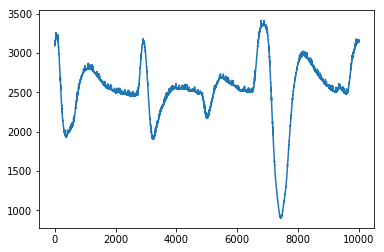

In [13]:
plt.plot(ripdata[:10000])

### Process the data

In [14]:
processed_data = resp.resp(signal=ripdata, sampling_rate=200, show=False)[1]

D:\Anaconda37\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


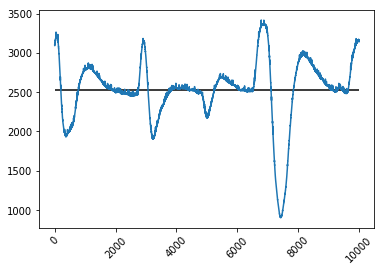

In [15]:
plot_first_data(ripdata, 10000)

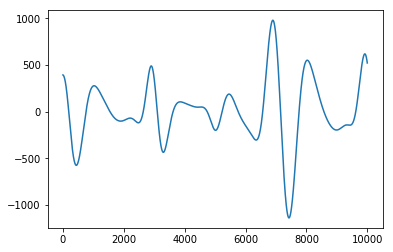

In [16]:
plt.plot(processed_data[:10000])

### Example (1)

In [17]:
xdata = (ripdata[10000:20000])

In [18]:
a_int, b_inout = calc_resp_intervals(xdata,last_breath=False)

[ 359  832 1289 1765 2217 2744 3668 4785 5208 5650 6245 7027 7463 7787
 8058 8627 9149 9631 9998]


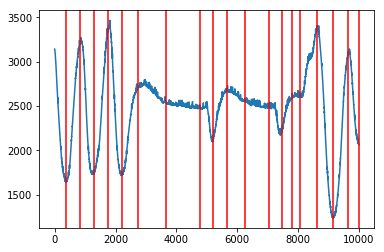

In [19]:
plt.plot(xdata)
points = a_int
print(np.cumsum(points))
for xc in np.cumsum(points):
    plt.axvline(x=xc, color='r')
    
# plt.plot(resp_changes[, 4000*np.ones(len(np.where(resp_changes < 10000))),'x')

[ 359  832 1289 1765 2217 2744 3668 4785 5208 5650 6245 7027 7463 7787
 8058 8627 9149 9631 9998]


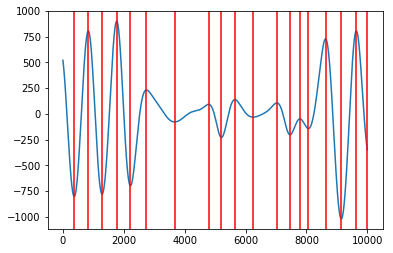

In [20]:
plt.plot(processed_data[10000:20000])
points = a_int
print(np.cumsum(points))
for xc in np.cumsum(points):
    plt.axvline(x=xc, color='r')
    


### Example (2)

### Inhale-Hold decay

In [21]:
init1 = 146000
end1 = 148000

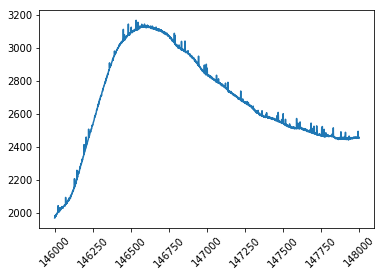

In [22]:
plot_slice_data(ripdata,146000,148000, False)

In [23]:
area_fraction(ripdata[146300:148000])

0.6730665498621323

### Exhale decay

In [24]:
init2 = 115000
end2 = 117000

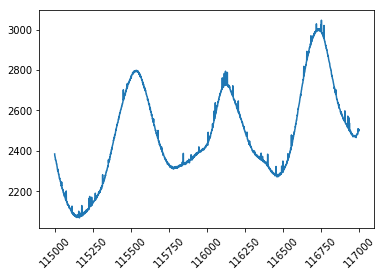

In [25]:
plot_slice_data(ripdata,init2,end2, False)

In [26]:
area_fraction(ripdata[init2:end2])

0.6057899169921875